# Whatsapp chat analyzer
## Usages:
- **count of who said more a specific word or set of word**  
    *input:* (Word : String, regex expression or list of String, chat file: file.txt ) 
    *output:* a table with times each person in the chat said the word   
    e.g.  
    *input*:('Tips', 'WA_chat_with_Reservoir_Dogs.txt')  
    *ouput*: 

|Mr.pink|Mr.white|Mr.green|
|-------|--------|--------|
|  123  |  414   |   12   |
        
    

## Counter
- First of all I've scraped the file to retireve the databases, the first one is the one with messages, the second one contains the changes to the group chat (removed members, added members, changed name, ...).  
- Then I proceeded to "clean" the first database, removing link and 'media omitted' messages.
- Finally I've made the counting script

In [115]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np

f = open('PATH_TO_YOUR_TXT', "r", encoding='utf-8') 

lines = f.readlines()
dates = []
times = []
authors = [] 
contents = []
change_dates = []
change_times = []
change_authors = []
change_actions = []
change_targets = []
i = 0
inserted = 0

for l in lines: # for each line of the file
    i += 1
    m = re.match(r'(.*), (.*) - (.*?): (.*)', l) # we're gonna extract the datas using regex, we can 'cause the file is formatted
    if m != None: # if we find something(most of the time) we're gonna add all the new data to our lists 
        inserted += 1 # and increment the number of match (we'll need this later)
        dates.append(m.group(1))
        times.append(m.group(2))
        authors.append(m.group(3))
        contents.append(m.group(4))
    else: # if we don't find the correct format is because a '\n' in the text of the message or because is not a message
        m = re.match(r'(.*), (.*) - ([A-Z].*) (.*) ([A-Z].*)', l) # we take another look if it's a changes to the group
        if m != None: # if it is we re gonna append to the others list
            change_dates.append(m.group(1))
            change_times.append(m.group(2))
            change_authors.append(m.group(3))
            change_actions.append(m.group(4))
            change_targets.append(m.group(5))
        else: # if it's not a change is the last part of the previous message so we 're gonna add it 
            contents[inserted-1] = contents[inserted-1] + " " + l.replace('\n', ' ')
           
        

datas = list(zip(dates, times, authors, contents))
change_datas = list(zip(change_dates, change_times, change_authors, change_actions, change_targets))

df = pd.DataFrame(datas, columns=['Dates', 'Time', 'Author', 'Contents']) # create the first dataframe with message
# create the second one with stuff like ('Mr. white changed the group's icon', 'Mr.Pink added Mr. yellow', ecc...)
# intially is a little crappy, we'll probably come back on it later to adjust it
change_df = pd.DataFrame(change_datas, columns=['Dates', 'Time', 'Author', 'Actions', 'Target'])

df.head()

,Dates,Time,Author,Contents
0,05/12/2016,19:42,Luca,Mah...
1,05/12/2016,19:42,Baru,E lo dice uno che pensava fosse una schifezza
2,05/12/2016,19:42,Luca,Non mi hanno mai ispirato i ff
3,05/12/2016,19:42,Baru,Manco a me
4,05/12/2016,19:42,Luca,Ho già visto un paio di gameplay


### Database manipolation
- Removed the 'Media omitted' messages

In [116]:
df = df.drop(df[df['Contents'] == '<Media omitted>'].index)

['Luca' 'Baru' 'Bruns' 'CREM' 'Geppo' 'Stefano Grossi' 'Gu' 'Zambo'
 'Ricky' 'Fabio Andreella' 'Luca Nam' 'Telli' 'Sara Renda' 'PERA🍐🍐❤👸🏼'
 'Alfre' 'Daniele Ferrhouse' 'Gigo' 'Carri']
18 Persone


### Hash table
I'll generate an hash table of n rows where n is the number of member of the group chat, the index in the list of each person will be determined by an hash function for string, for collision i'll use the line probing method.  
Function = $h(str) = (str[len-1]*26^{(len-1)} + str[len-2]*26^{(len-2)} + ... + str[0]*26^0$

In [117]:
def hash_funct(word, tab_lenght): # this is the hash funct for retrieving the index for a given string
    index = 0
    for char, i in zip(word, range(len(word))): # cycling through characters
        index += (ord(char.lower()) - 96) * 26 ** (len(word)-1-i) 
    index = index % tab_lenght
    return index

In [118]:
def generate_tab(list_of_string): 
    tab = [None] * len(list_of_string)
    for string in list_of_string: # for each string in the list
        index = hash_funct(string, len(list_of_string)) # i get the index from the funct
        while tab[index] != None: # linear probing for collision
            index += 1
            if index == len(list_of_string): # if I get too high with the index i'll set that to 0
                index = 0
        tab[index] = string # set the value of index-th value of the string as the name
    return tab

authors = df['Author'].unique()
hash_tab = generate_tab(authors) # generating hash_tab
for i in range(len(hash_tab)):
    print(i, ": ", hash_tab[i])

0 :  Ricky
1 :  Bruns
2 :  Telli
3 :  Sara Renda
4 :  Daniele Ferrhouse
5 :  CREM
6 :  Gu
7 :  Luca
8 :  Luca Nam
9 :  Alfre
10 :  PERA🍐🍐❤👸🏼
11 :  Baru
12 :  Gigo
13 :  Stefano Grossi
14 :  Carri
15 :  Zambo
16 :  Fabio Andreella
17 :  Geppo


### Counting
From here the function that will count the occurances of the given word

In [120]:
def count(data, words, hash_tab):
    classifica = [0]*len(hash_tab) # init of the list, all the values are = 0
    contents = list(data['Contents'])
    authors = list(data['Author'])
    for message, i in zip(contents, range(len(contents))): # for each message
        message = message.lower()
        for word in words: # for each word in the list of word to check for
            if word in message: # if the word is into the message 
                index = hash_funct(authors[i], len(hash_tab)) # generate the index with the hash function
                while hash_tab[index] != authors[i]: # if at the index-th position i don't find the right author 
                    index += 1 # it means that generating the hash_tab there's been a collision so add 1 to index
                    if(index == len(hash_tab)):
                        index = 0 # reset when going over lenght of array
                classifica[index] += 1 # now i got the right index so i'll increment the value at that index by one
    return classifica

In [151]:
# list of words to search
to_search = []

classifica = count(df, to_search, hash_tab) # ranking list, organized like this: 
classifica_dict = {}                        # at index i ther is the score of i-th person in hash_tab
for partecipante, score in zip(hash_tab, classifica): # zipping the 2 array into a dictionary, dropping who has score=0
    if score != 0:
        classifica_dict.update({partecipante : score})

### Plotting
- Plotting an histogram for rankings 
- Plotting a pie chart (total is the total occurance of the words and the peace are how much did a person contributed)

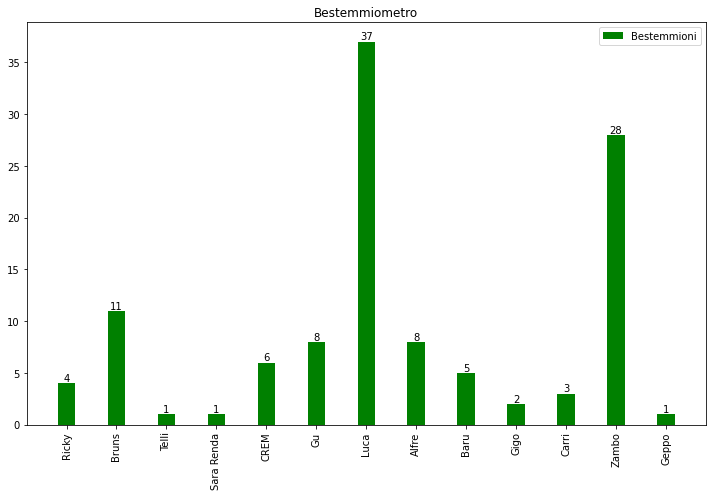

In [150]:
fig, ax = plt.subplots(figsize=[10, 7])
width = 0.35

bars = ax.bar(classifica_dict.keys(), classifica_dict.values(), width=width, label='Bestemmioni', color='green')


for bar in bars:
    height = bar.get_height()
    ax.annotate('{}'.format(height), 
                    xy=(bar.get_x() + bar.get_width()/2, height), 
                    xytext=(0, 0),
                    textcoords="offset points", 
                    ha='center', va='bottom') 
    
ax.legend()
plt.xticks(rotation=90)
str = ""
for item, i in zip(to_search, range(len(to_search))):
        str += item + ' '
        if i % 3 == 0:
            str += '\n'
ax.set_title('Bestemmiometro')
fig.tight_layout() 
fig.savefig('Jasstemmoni.png')